In [2]:
import pandas as pd

data = pd.read_excel("HCMWeatherDaily.xlsx")

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3934 entries, 0 to 3933
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3934 non-null   object 
 1   datetime          3934 non-null   object 
 2   tempmax           3934 non-null   float64
 3   tempmin           3934 non-null   float64
 4   temp              3934 non-null   float64
 5   feelslikemax      3934 non-null   float64
 6   feelslikemin      3934 non-null   float64
 7   feelslike         3934 non-null   float64
 8   dew               3934 non-null   float64
 9   humidity          3934 non-null   float64
 10  precip            3934 non-null   float64
 11  precipprob        3934 non-null   int64  
 12  precipcover       3934 non-null   float64
 13  preciptype        3013 non-null   object 
 14  snow              3934 non-null   int64  
 15  snowdepth         3934 non-null   int64  
 16  windgust          3934 non-null   float64


# Step1: Understanding Data

| Column             | Meaning                      | Values / Units  | Notes                                   |
| ------------------ | ---------------------------- | --------------- | --------------------------------------- |
| `name`             | Location / station label     | Text            | Use as ID for multi-location data.      |
| `datetime`         | Timestamp of record          | ISO-8601        | Parse to datetime; time index.          |
| `tempmax`          | Daily max air temperature    | ¬∞C              | Common regression target.               |
| `tempmin`          | Daily min air temperature    | ¬∞C              | Nighttime cooling proxy.                |
| `temp`             | Daily mean air temperature   | ¬∞C              | Seasonal baseline.                      |
| `feelslikemax`     | Max apparent temperature     | ¬∞C              | From temp+humidity+wind.                |
| `feelslikemin`     | Min apparent temperature     | ¬∞C              |                                         |
| `feelslike`        | Mean apparent temperature    | ¬∞C              | Often collinear with `temp`.            |
| `dew`              | Dew point                    | ¬∞C              | Good moisture measure (for VPD).        |
| `humidity`         | Relative humidity            | 0‚Äì100 %         | Bounded variable.                       |
| `precip`           | Total precipitation          | mm (daily)      | Zero‚Äëinflated; consider log1p.          |
| `precipprob`       | Chance of precipitation      | 0‚Äì100 %         | Treat as exogenous forecast if present. |
| `precipcover`      | % of time with precipitation | 0‚Äì100 %         | Duration signal.                        |
| `preciptype`       | Type of precipitation        | Categorical     | e.g., rain/snow/sleet; null ‚áí none.     |
| `snow`             | Snowfall amount              | mm (or cm)      | Often 0 in warm climates.               |
| `snowdepth`        | Snow depth on ground         | mm (or cm)      | Strong persistence.                     |
| `windgust`         | Max wind gust                | km/h or m/s     | Extremes during storms.                 |
| `windspeed`        | Mean wind speed              | km/h or m/s     | Drives wind chill/evaporation.          |
| `winddir`          | Wind direction               | 0‚Äì360¬∞          | Encode as sin/cos.                      |
| `sealevelpressure` | Sea‚Äëlevel pressure           | hPa             | Use changes Œîpressure.                  |
| `cloudcover`       | Sky cloud cover              | 0‚Äì100 %         | Controls solar input.                   |
| `visibility`       | Horizontal visibility        | km              | Fog/haze/rain effects.                  |
| `solarradiation`   | Mean solar irradiance        | W/m¬≤            | Solar + clouds.                         |
| `solarenergy`      | Total solar energy           | MJ/m¬≤ or kWh/m¬≤ | Daily integral.                         |
| `uvindex`          | UV exposure index            | 0‚Äì11+           | Proxy for sky clarity.                  |
| `severerisk`       | Severe weather risk score    | 0‚Äì1 or 0‚Äì100    | Often sparse; may impute 0.             |
| `sunrise`          | Local sunrise time           | Local time      | With sunset ‚Üí daylength.                |
| `sunset`           | Local sunset time            | Local time      |                                         |
| `moonphase`        | Lunar phase fraction         | 0‚Äì1             | 0=new, 0.5=full.                        |
| `conditions`       | Condition label              | Text            | e.g., Clear, Rain.                      |
| `description`      | Text description             | Text            | Narrative summary.                      |
| `icon`             | Icon code                    | Category        | e.g., `clear-day`, `rain`.              |
| `stations`         | Contributing station IDs     | List/Text       | For QC/audits.                          |



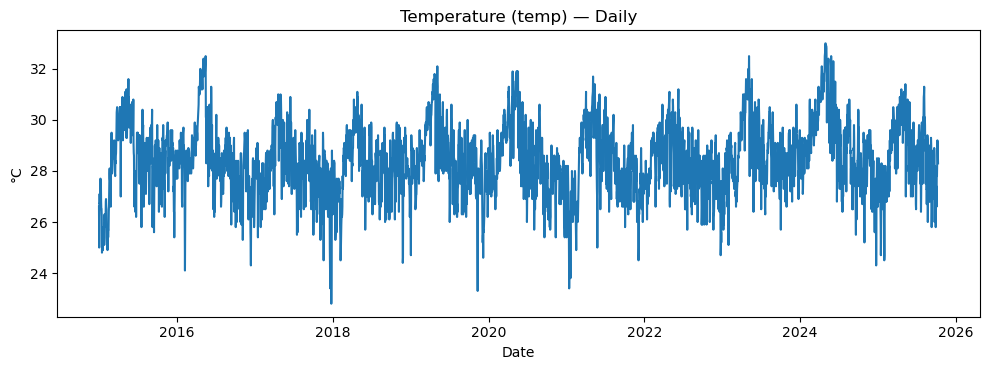

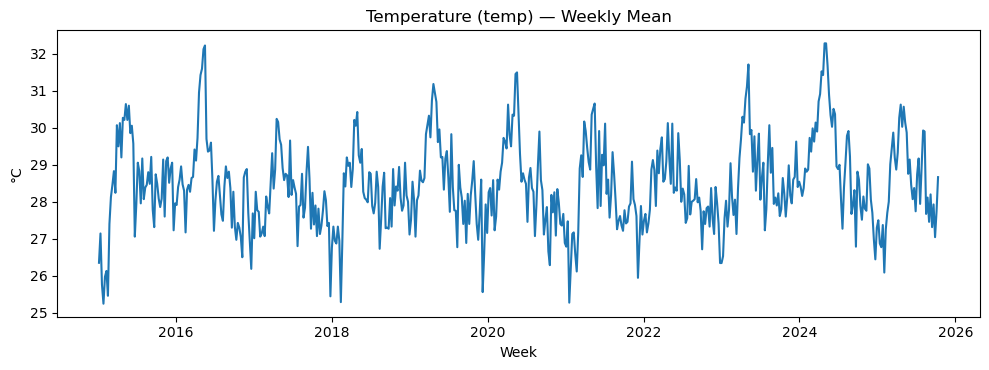

/var/folders/16/yn17n1916z32xtfrqrq39zj00000gn/T/ipykernel_78256/4057697350.py:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  temp_month = s.resample("M").mean()


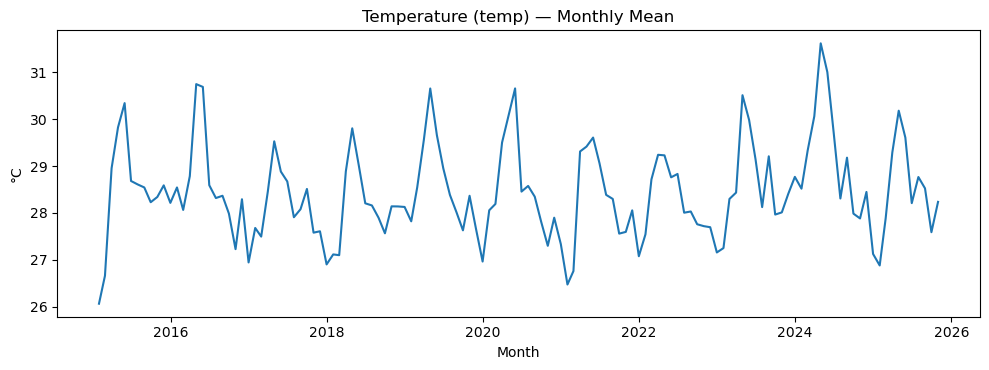

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Gi·∫£ s·ª≠ DataFrame c·ªßa b·∫°n l√† `data` v·ªõi c·ªôt 'datetime' v√† 'temp'
df = data.copy()

# B·∫£o ƒë·∫£m datetime + sort
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df = df.dropna(subset=["datetime"]).sort_values("datetime").set_index("datetime")

s = df["temp"]

# 1) DAILY: plot tr·ª±c ti·∫øp, kh√¥ng t√≠nh mean l·∫°i
plt.figure(figsize=(10, 3.8))
plt.plot(s.index, s.values)
plt.title("Temperature (temp) ‚Äî Daily")
plt.xlabel("Date")
plt.ylabel("¬∞C")
plt.tight_layout()
plt.show()

# 2) WEEKLY: l·∫•y trung b√¨nh theo tu·∫ßn (m·∫∑c ƒë·ªãnh tu·∫ßn k·∫øt th√∫c Ch·ªß nh·∫≠t; d√πng 'W-MON' n·∫øu mu·ªën tu·∫ßn ISO)
temp_week = s.resample("W").mean()

plt.figure(figsize=(10, 3.8))
plt.plot(temp_week.index, temp_week.values)
plt.title("Temperature (temp) ‚Äî Weekly Mean")
plt.xlabel("Week")
plt.ylabel("¬∞C")
plt.tight_layout()
plt.show()

# 3) MONTHLY: l·∫•y trung b√¨nh theo th√°ng (k·∫øt th√∫c th√°ng)
temp_month = s.resample("M").mean()

plt.figure(figsize=(10, 3.8))
plt.plot(temp_month.index, temp_month.values)
plt.title("Temperature (temp) ‚Äî Monthly Mean")
plt.xlabel("Month")
plt.ylabel("¬∞C")
plt.tight_layout()
plt.show()


## Ho Chi Minh City Temperature (2015‚Äì2025): Descriptive Overview

> **Scope:** This section provides *descriptive statistics/observations only* to establish a high-level view of Ho Chi Minh City‚Äôs daily temperature(mean) over the last 10 years. 

### Executive Summary

Across 2015‚Äì2025, Ho Chi Minh City exhibits a **stable tropical monsoon pattern** with **clear seasonality** and a **modest upward drift in pre‚Äëmonsoon peaks** in recent years. Day‚Äëto‚Äëday variability is limited; differences are driven primarily by the annual cycle.

### Data & Method

* Daily temperature time series aggregated to **weekly** and **monthly** means to reveal trend and seasonality.
* Periods of interest: **peak (Apr‚ÄìMay)** and **trough (Dec‚ÄìJan)** each year.
* Metrics reviewed: daily range, weekly/monthly mean levels, recurrence and intensity of hot spells.

### Key Descriptive Findings

* **Seasonality**

  * **Pre‚Äëmonsoon peak (Apr‚ÄìMay):** monthly means typically **‚âà30‚Äì32‚ÄØ¬∞C**; recent years show more frequent short **hot spells**.
  * **Rainy season (Jun‚ÄìOct):** temperatures **stabilize or ease** to **‚âà27‚Äì29‚ÄØ¬∞C** despite storm‚Äëdriven daily noise.
  * **Year‚Äëend dip (Dec‚ÄìJan):** the relative minimum, monthly means **‚âà26‚Äì27‚ÄØ¬∞C**.
* **Decadal drift**

  * **Slight increase in hot‚Äëseason crests** over the decade, with **2023‚Äì2025** often touching the **upper end of the 31‚Äì32‚ÄØ¬∞C band**.
* **Day‚Äëto‚Äëday variability**

  * Most days fall between **26‚Äì31‚ÄØ¬∞C**; **interday swings are modest**, consistent with a humid tropical urban climate.

### Interpretation (Descriptive)

The city‚Äôs **thermal structure remains intact**‚Äîwarming from early year to an Apr‚ÄìMay crest, then a rainy‚Äëseason plateau, followed by a late‚Äëyear easing. The **recent amplification of short heatwaves** is visible yet does not alter the underlying seasonal cadence.


## Univariate Analysis(Not Required But For Better Data Understanding) - B·∫£o l√†m th√¨ l√†m ng·∫Øn g·ªçn, 

In [5]:
# Core
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter display
from IPython.display import display, HTML

# Style
sns.set_theme(context="notebook", style="whitegrid")
pd.set_option("display.max_colwidth", 200)

# D√πng b·∫£n sao ƒë·ªÉ an to√†n
df = data.copy()

# Chu·∫©n ho√° t√™n c·ªôt
df.columns = [c.strip() for c in df.columns]

# √âp ki·ªÉu datetime n·∫øu c√≥ c·ªôt 'datetime'
if "datetime" in df.columns:
    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

# Nh·∫≠n di·ªán ki·ªÉu d·ªØ li·ªáu
numeric_cols   = df.select_dtypes(include=[np.number]).columns.tolist()
datetime_cols  = df.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
bool_cols      = df.select_dtypes(include=["bool"]).columns.tolist()
object_cols    = df.select_dtypes(include=["object"]).columns.tolist()

print("Shape:", df.shape)
print("Numeric:", len(numeric_cols), "cols")
print("Datetime:", len(datetime_cols), "cols")
print("Boolean:", len(bool_cols), "cols")
print("Object:", len(object_cols), "cols")


Shape: (3934, 33)
Numeric: 24 cols
Datetime: 1 cols
Boolean: 0 cols
Object: 8 cols


In [6]:
# T·ª∑ l·ªá thi·∫øu theo c·ªôt
missing_ratio = df.isna().mean().sort_values(ascending=False).to_frame("missing_ratio")
display(missing_ratio.style.background_gradient(cmap="Reds").format("{:.1%}"))

# Th·ªëng k√™ m√¥ t·∫£ cho c·ªôt s·ªë
if numeric_cols:
    desc_num = df[numeric_cols].describe().T
    display(desc_num.style.format("{:.3f}").bar(subset=["mean"], color="#a6cee3"))
else:
    print("No numeric columns.")


In [7]:
import math

def plot_numeric_histograms(df, cols, bins="auto", ncols=2, height=3.2, kde=True):
    if not cols:
        print("No numeric columns to plot.")
        return
    
    n = len(cols)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, height*nrows))
    axes = np.atleast_1d(axes).flatten()
    
    for ax, col in zip(axes, cols):
        s = df[col].dropna()
        if s.empty:
            ax.set_visible(False)
            continue
        sns.histplot(s, bins=bins, kde=kde, ax=ax)
        ax.set_title(f"{col} (n={len(s)})")
        ax.set_xlabel(col); ax.set_ylabel("count")
        # mean/median
        m = s.mean(); med = s.median()
        ax.axvline(m, ls="--", lw=1, label=f"mean={m:.2f}")
        ax.axvline(med, ls="-.", lw=1, label=f"median={med:.2f}")
        ax.legend(loc="upper right", fontsize=8)
    
    # ·∫®n axes d∆∞
    for ax in axes[n:]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()

def plot_numeric_boxplots(df, cols, ncols=2, height=3.2):
    if not cols:
        print("No numeric columns to plot.")
        return
    
    n = len(cols)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, height*nrows))
    axes = np.atleast_1d(axes).flatten()
    
    for ax, col in zip(axes, cols):
        s = df[col].dropna()
        if s.empty:
            ax.set_visible(False)
            continue
        sns.boxplot(x=s, ax=ax)
        ax.set_title(f"{col} ‚Äî boxplot")
        ax.set_xlabel(col)
    
    for ax in axes[n:]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()

def plot_topk_categorical(df, col, k=20):
    vc = df[col].dropna().astype(str).value_counts().head(k)
    if vc.empty:
        print(f"{col}: empty.")
        return
    plt.figure(figsize=(8, 4))
    sns.barplot(x=vc.values, y=vc.index)
    plt.title(f"{col} ‚Äî Top {k}")
    plt.xlabel("count"); plt.ylabel(col)
    plt.tight_layout()
    plt.show()

def explode_multilabel(series, sep=","):
    s = series.dropna().astype(str).str.split(sep)
    s = s.explode().str.strip()
    return s[s != ""]


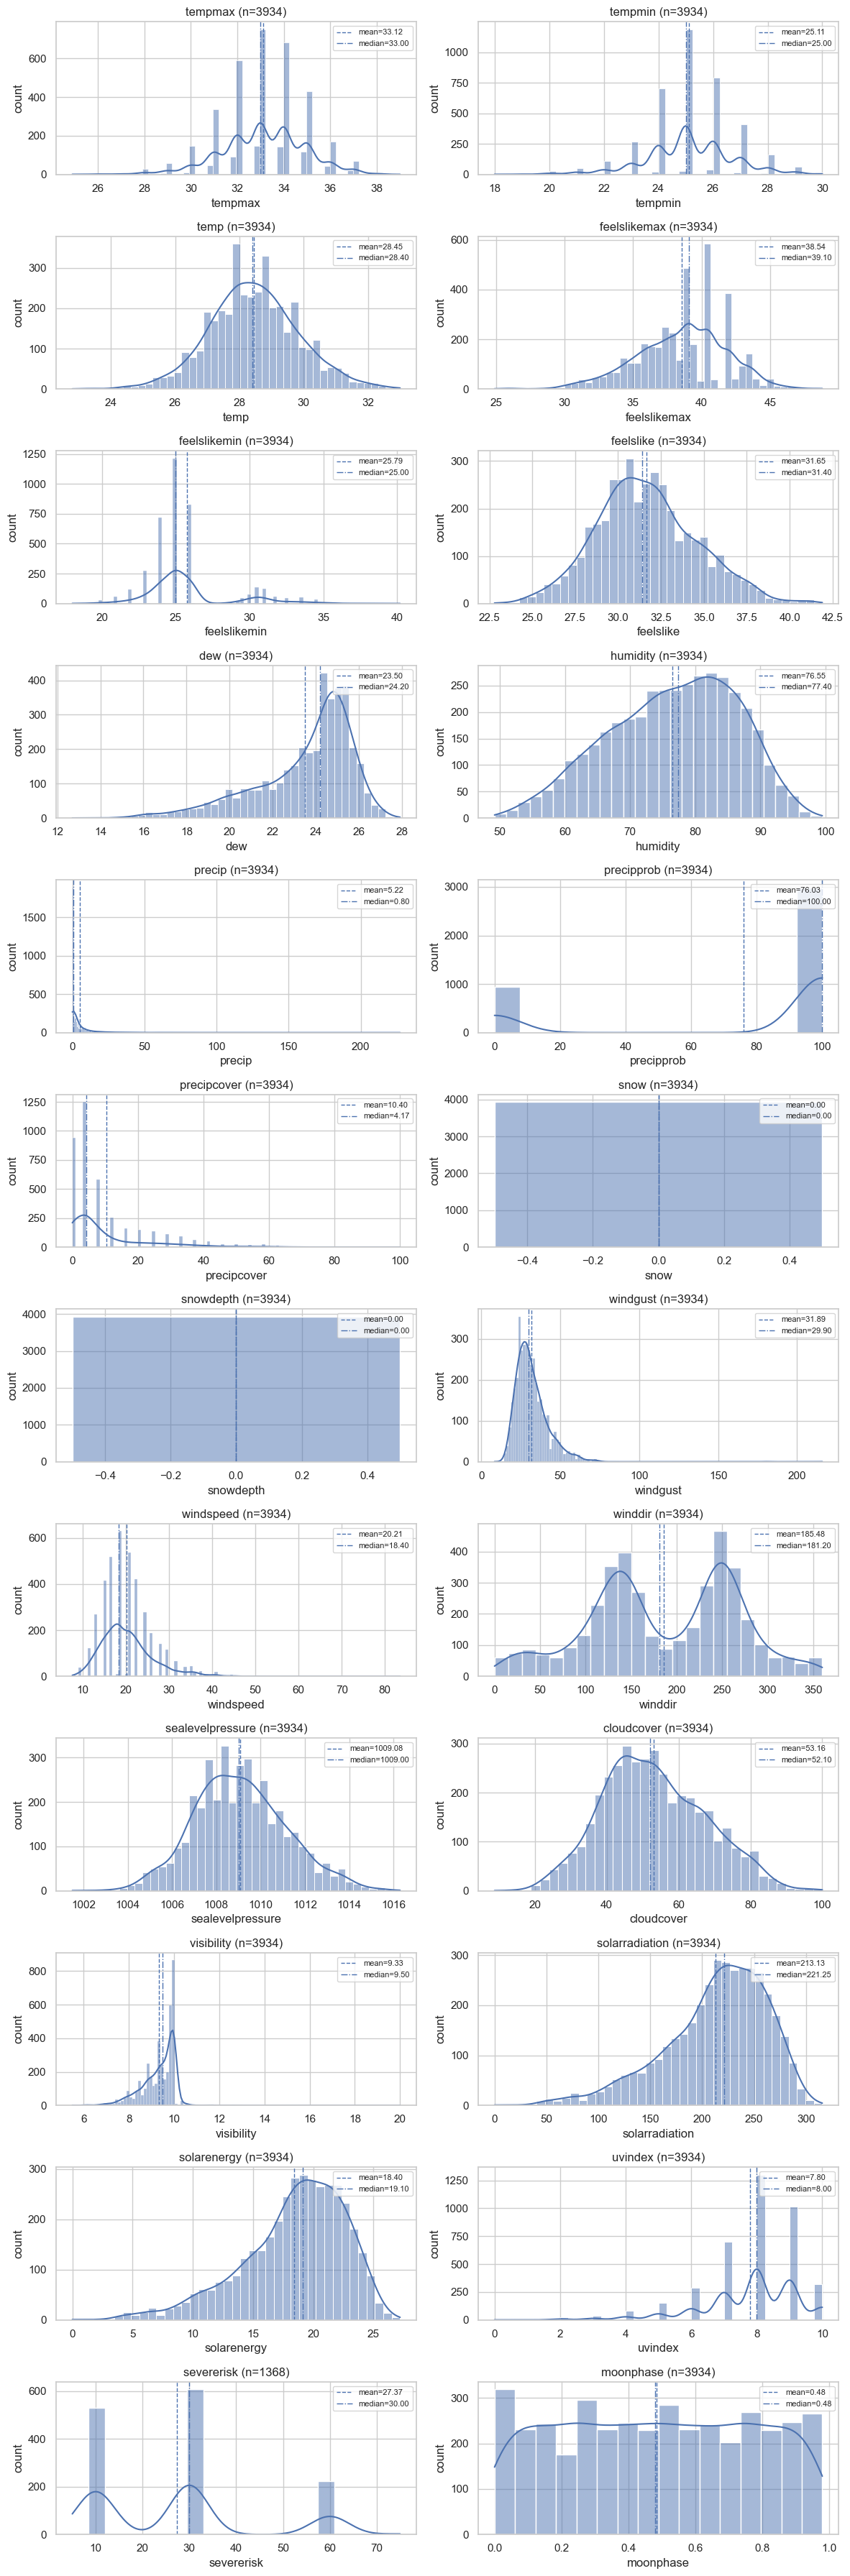

In [8]:
plot_numeric_histograms(df, numeric_cols, bins="auto", ncols=2, height=3.0, kde=True)


==> name


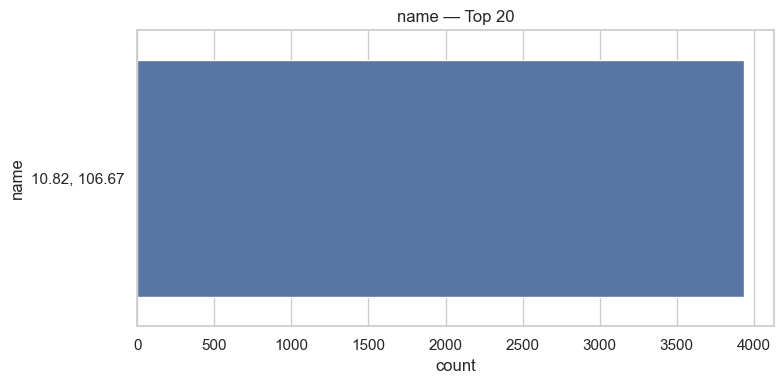

==> preciptype


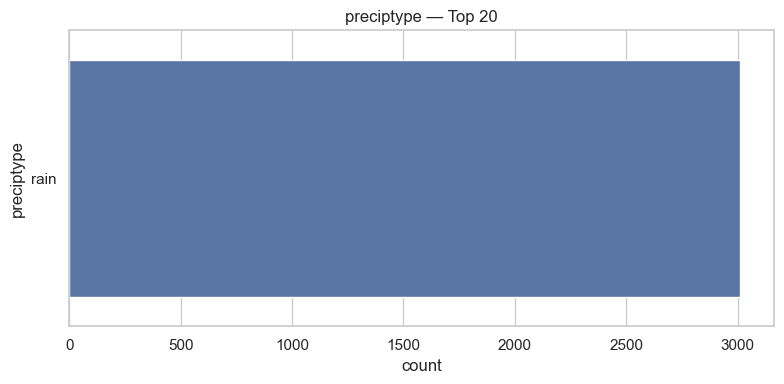

==> sunrise


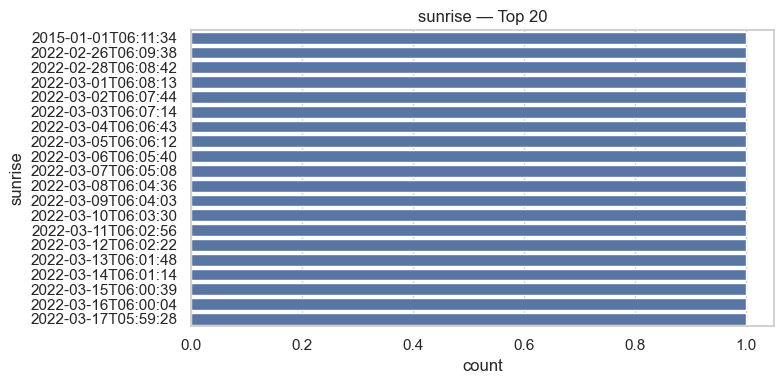

==> sunset


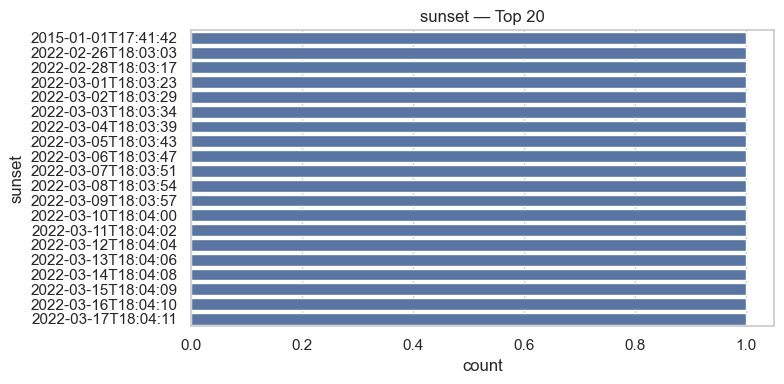

==> conditions


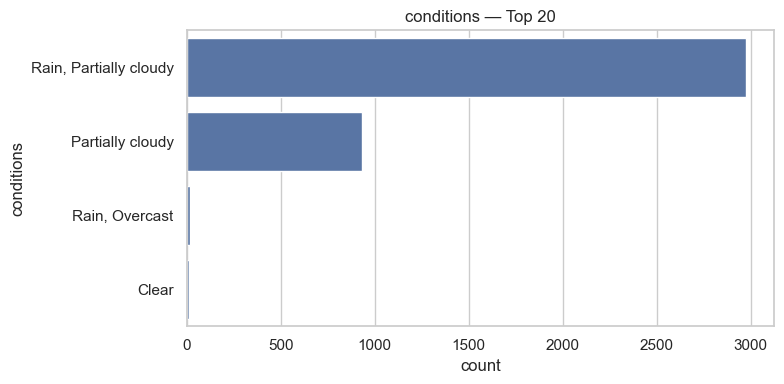

==> description


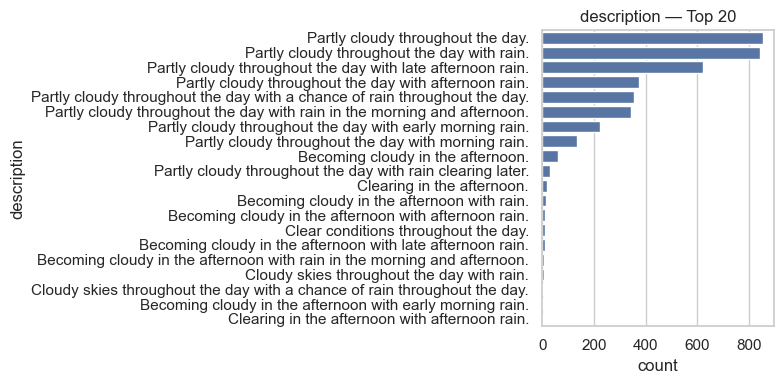

==> icon


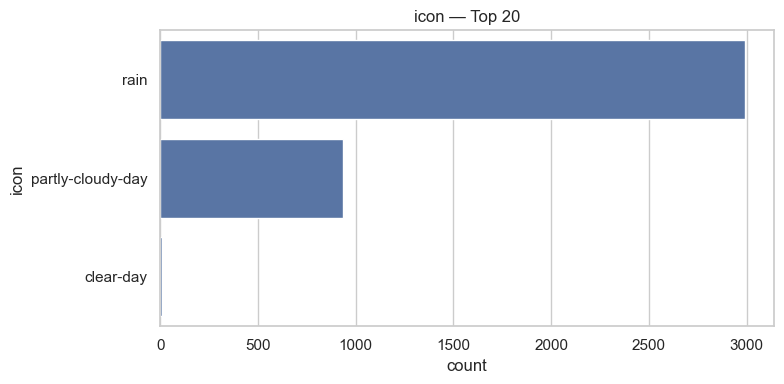

==> stations


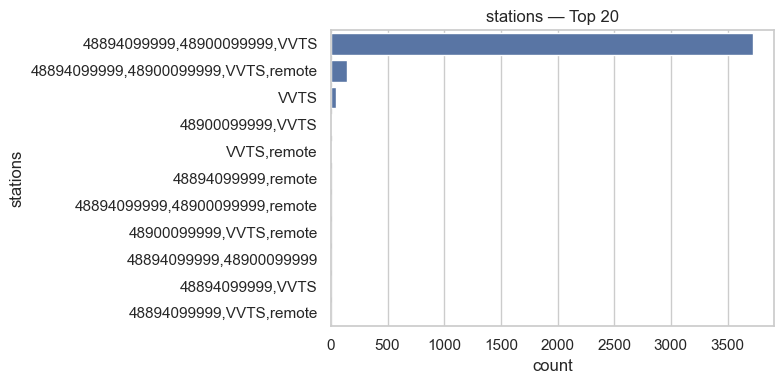

In [9]:
if object_cols:
    for col in object_cols:
        print(f"==> {col}")
        plot_topk_categorical(df, col, k=20)
else:
    print("No object (categorical) columns.")


## Multivariate Analysis - Relationship betwween features 

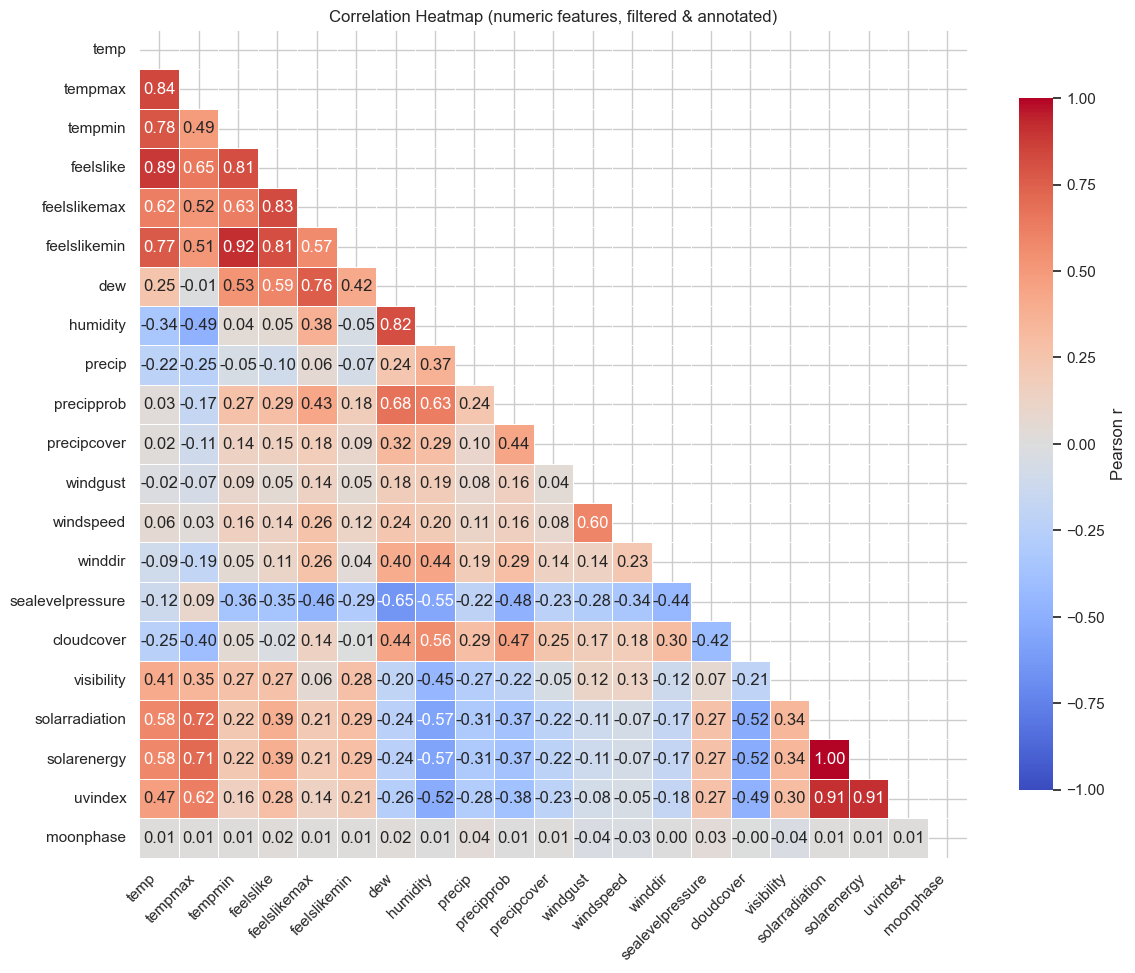

Selected numeric features (after filtering):
['temp', 'tempmax', 'tempmin', 'feelslike', 'feelslikemax', 'feelslikemin', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'moonphase']


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_ = df.copy()

# 1) L·∫•y numeric + l·ªçc theo ƒë·ªô ƒë·∫ßy ƒë·ªß d·ªØ li·ªáu (>=90% kh√¥ng b·ªã NaN)
num_cols_all = df_.select_dtypes(include=[np.number]).columns.tolist()
non_null_ratio = df_[num_cols_all].notna().mean()
candidate_cols = non_null_ratio[non_null_ratio >= 0.90].index.tolist()

# 2) Lo·∫°i c·ªôt h·∫±ng (kh√¥ng bi·∫øn thi√™n)
constant_cols = [c for c in candidate_cols if df_[c].nunique(dropna=True) <= 1]
selected = [c for c in candidate_cols if c not in constant_cols]

# 3) (Tu·ª≥ ch·ªçn) S·∫Øp x·∫øp l·∫°i ƒë·ªÉ c√°c bi·∫øn ‚Äúkh√≠ t∆∞·ª£ng l√µi‚Äù l√™n tr∆∞·ªõc
priority_order = [
    "temp", "tempmax", "tempmin", "feelslike", "feelslikemax", "feelslikemin",
    "dew", "humidity", "precip", "precipprob", "precipcover",
    "windgust", "windspeed", "winddir",
    "sealevelpressure", "cloudcover", "visibility",
    "solarradiation", "solarenergy", "uvindex", "moonphase"
]
ordered = [c for c in priority_order if c in selected] + [c for c in selected if c not in priority_order]

# 4) T√≠nh Pearson correlation tr√™n nh√≥m ƒë√£ ch·ªçn
corr = df_[ordered].corr(method="pearson")

# 5) ƒê∆∞a 'temp' l√™n ƒë·∫ßu h√†ng/c·ªôt ƒë·ªÉ d·ªÖ ƒë·ªëi chi·∫øu (n·∫øu c√≥)
if "temp" in corr.columns:
    order = ["temp"] + [c for c in corr.columns if c != "temp"]
    corr = corr.loc[order, order]

# 6) V·∫Ω heatmap tam gi√°c d∆∞·ªõi + s·ªë t∆∞∆°ng quan
mask = np.triu(np.ones_like(corr, dtype=bool))  # che tam gi√°c tr√™n
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    vmin=-1, vmax=1, center=0,
    square=True,
    linewidths=0.5,
    annot=True, fmt=".2f",  # hi·ªÉn th·ªã s·ªë
    cbar_kws={"shrink": 0.8, "label": "Pearson r"},
)
plt.title("Correlation Heatmap (numeric features, filtered & annotated)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Selected numeric features (after filtering):")
print(list(corr.columns))


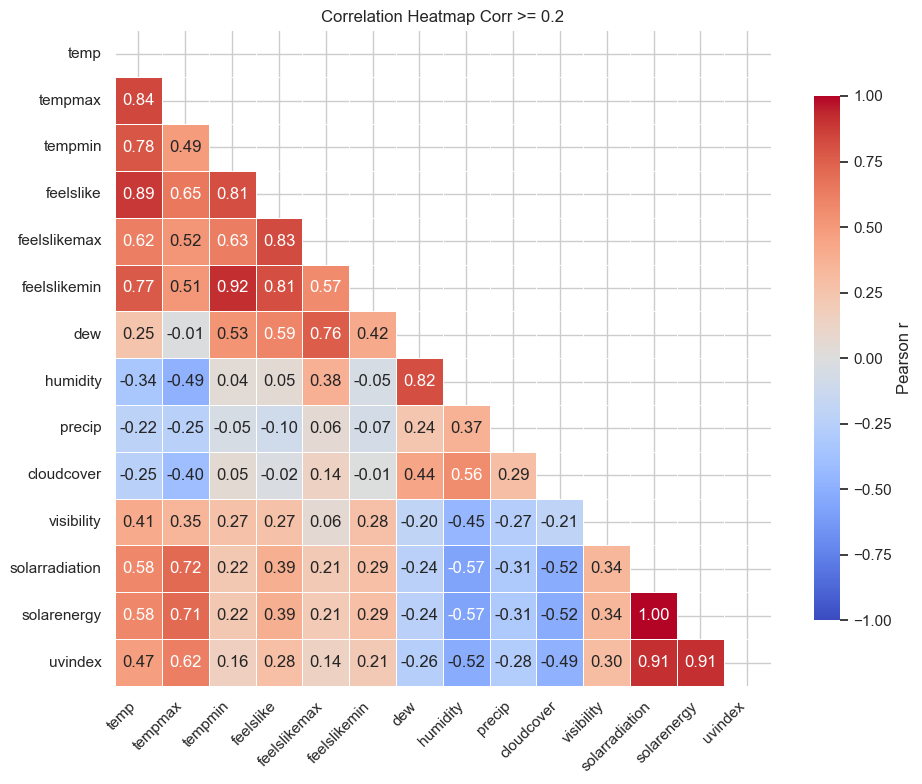

In [11]:
thr = 0.2
corr_temp = corr["temp"].drop("temp").abs()
keep = ["temp"] + corr_temp[corr_temp >= thr].index.tolist()
corr_sub = corr.loc[keep, keep]

mask = np.triu(np.ones_like(corr_sub, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_sub, mask=mask, cmap="coolwarm", vmin=-1, vmax=1, center=0,
    square=True, linewidths=0.5, annot=True, fmt=".2f",
    cbar_kws={"shrink": 0.8, "label": "Pearson r"}
)
plt.title(f"Correlation Heatmap Corr >= 0.2")
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()


### üå°Ô∏è Exploring Linear Relationships Between Weather Features and Hanoi Temperature

The correlation heatmap visualizes the **linear (Pearson) relationships** among key weather variables to understand how different factors may combine to explain or predict **Hanoi‚Äôs temperature (`temp`)**.  
It focuses purely on **linear dependencies**, meaning each coefficient describes how strongly and in which direction one variable changes *linearly* with another.

---

#### üî∏ 1. Strong Linear Relationships ‚Äî Temperature and Its Variants
- The variables **`tempmax`**, **`tempmin`**, **`feelslike`**, **`feelslikemax`**, and **`feelslikemin`** are all **strongly correlated** with `temp` (r ‚âà 0.75‚Äì0.90).  
  These represent different temperature measures (actual, perceived, daily max/min) and hence move almost linearly together.  
  ‚Üí Example: When the daily maximum temperature increases, the average and perceived temperature also increase proportionally.  
  This shows the **core ‚Äúthermal block‚Äù** of features with very similar information content.

---

#### üî∏ 2. Moderate Linear Relationships ‚Äî Solar and Atmospheric Factors
- **Solar-related variables** (`solarradiation`, `solarenergy`, `uvindex`) show **moderate-to-strong positive linear correlations** with `temp` (r ‚âà 0.5‚Äì0.6).  
  ‚Üí On sunny days, solar radiation and UV index rise together with air temperature ‚Äî indicating that **solar intensity is a key linear driver** of temperature changes.  
  These variables are also **highly intercorrelated** (r > 0.9), meaning they measure related aspects of sunlight energy (instantaneous vs. accumulated).

- **`dew`** has a **moderate positive correlation** with `temp` (r ‚âà 0.5‚Äì0.6), implying that warmer air usually holds more moisture before reaching saturation.  
  This suggests that **humidity and temperature are linearly coupled through dew point**.

---

#### üî∏ 3. Negative Linear Relationships ‚Äî Cooling and Moisture Effects
- **`humidity`** exhibits a **negative correlation** with `temp` (r ‚âà -0.3 to -0.5).  
  ‚Üí Higher humidity tends to accompany cooler days due to less solar heating and evaporative balance in the air.  
  This inverse linear relation highlights that when the air is saturated, the energy used for evaporation limits temperature increases.

- **`precip`** and **`cloudcover`** are also **negatively correlated** with `temp` and solar variables (r ‚âà -0.4 to -0.6).  
  ‚Üí Rainy or cloudy conditions block sunlight, reducing solar radiation and consequently lowering temperature.  
  These negative correlations form a **‚Äúcooling cluster‚Äù** of variables that linearly oppose thermal and solar indicators.

---

#### üî∏ 4. Smaller Linear Contributions
- **`visibility`** shows weak-to-moderate positive correlations with temperature (r ‚âà 0.3‚Äì0.4).  
  ‚Üí Clearer atmospheric conditions often coincide with warmer and drier days, possibly due to less cloud and haze.

---

#### üî∏ 5. Summary of Linear Interaction Patterns
| Cluster | Variables | Linear Relation to `temp` | Interpretation |
|:--|:--|:--|:--|
| **Thermal cluster** | `tempmax`, `tempmin`, `feelslike`, `feelslikemax`, `feelslikemin` | Strong positive | Different measures of air temperature ‚Äî move almost proportionally |
| **Solar cluster** | `solarradiation`, `solarenergy`, `uvindex` | Moderate‚Äìstrong positive | Solar intensity drives daytime warming |
| **Moisture cluster** | `humidity`, `dew` | Mixed (dew +, humidity -) | Moisture level affects how air warms |
| **Weather effects** | `precip`, `cloudcover`, `visibility` | Mostly negative | Clouds and rain limit solar heating, reducing temperature |

---

#### üî∏ 6. Implication for Temperature Modeling
- These **linear relationships** show that **temperature in Hanoi can be linearly approximated** as a combination of:
  - Positive contributors: solar radiation, UV index, dew point, and other temperature measures.
  - Negative contributors: humidity, cloud cover, precipitation.
- However, this only captures **linear dependencies**. Real-world temperature patterns may involve **non-linear or time-dependent interactions** (e.g., lag effects, seasonality, or atmospheric feedback), which linear correlation cannot express.

---

üß≠ **Conclusion:**  
The heatmap provides a clear **linear overview** of how different weather components interact around temperature.  
To **detect or predict Hanoi‚Äôs temperature**, a model can start with these strong linear predictors, while later introducing non-linear terms or lag features to capture more complex dynamics of the climate system.


### NOTE: ƒê√ÇY l√† quan h·ªá tuy·∫øn t√≠nh gi·ªØa c√°c feature th√¥i, kh√¥ng capture ƒë∆∞·ª£c quan h·ªá phi tuy·∫øn n·∫øu c√≥, B·∫£o nghi√™n c√∫u th√™m. Ch∆∞a ph√¢n t√≠ch s√¢u t·ª´ng c·∫∑p, ch·ªâ overview qua heatmap, n√™n ph√¢n t√≠ch ri√™ng c√°c c·∫≠p ƒë·∫∑c bi·ªát d√πng bi·ªÉu ƒë·ªì nh∆∞ scatter,... Ch·ªâ g·ªìm m·ªëi quan h·ªá gi·ªØa c√°c bi·∫øn numeric c·∫ßn ph√¢n t√≠ch th√™m c√°c bi·∫øn categorical/object, d√πng bi·ªÉu ƒë·ªì box-plot, violin-plot,...


# Step 3: Data Processing

## 3.1 Handling Missing Values ‚Äî 'precipetype', 'severerisk'

In [12]:
# Chuy·ªÉn ki·ªÉu d·ªØ li·ªáu cho c√°c c·ªôt th·ªùi gian
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
data['sunrise']  = pd.to_datetime(data['sunrise'], errors='coerce')
data['sunset']   = pd.to_datetime(data['sunset'], errors='coerce')

# Ki·ªÉm tra l·∫°i ki·ªÉu d·ªØ li·ªáu sau khi chuy·ªÉn
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3934 entries, 0 to 3933
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   name              3934 non-null   object        
 1   datetime          3934 non-null   datetime64[ns]
 2   tempmax           3934 non-null   float64       
 3   tempmin           3934 non-null   float64       
 4   temp              3934 non-null   float64       
 5   feelslikemax      3934 non-null   float64       
 6   feelslikemin      3934 non-null   float64       
 7   feelslike         3934 non-null   float64       
 8   dew               3934 non-null   float64       
 9   humidity          3934 non-null   float64       
 10  precip            3934 non-null   float64       
 11  precipprob        3934 non-null   int64         
 12  precipcover       3934 non-null   float64       
 13  preciptype        3013 non-null   object        
 14  snow              3934 n

### Feature Type Identification ‚Äî Ho Chi Minh City Weather Dataset

| Column            | Dtype    | Feature Type          | Notes |
|-------------------|----------|-----------------------|-------|
| name              | object   | Categorical (nominal) | Location/site name |
| datetime          | datetime64[ns]   | Datetime              | Convert to `datetime64` |
| tempmax           | float64  | Numerical (continuous)| Daily max temperature |
| tempmin           | float64  | Numerical (continuous)| Daily min temperature |
| **temp**          | float64  | **Numerical (target)**| Target variable |
| feelslikemax      | float64  | Numerical (continuous)| Heat index (max) |
| feelslikemin      | float64  | Numerical (continuous)| Heat index (min) |
| feelslike         | float64  | Numerical (continuous)| Heat index (avg) |
| dew               | float64  | Numerical (continuous)| Dew point |
| humidity          | float64  | Numerical (continuous)| Relative humidity (%) |
| precip            | float64  | Numerical (continuous)| Precipitation (mm) |
| precipprob        | int64    | Numerical (discrete)  | Probability (%) |
| precipcover       | float64  | Numerical (continuous)| % of day with precip |
| preciptype        | object   | Categorical (nominal) | e.g., rain/snow/none (missing allowed) |
| snow              | int64    | Numerical (discrete)  | Snowfall amount |
| snowdepth         | int64    | Numerical (discrete)  | Snow depth |
| windgust          | float64  | Numerical (continuous)| Max gust speed |
| windspeed         | float64  | Numerical (continuous)| Avg wind speed |
| winddir           | float64  | Numerical (continuous)| Wind direction (¬∞) ‚Äî **cyclical** |
| sealevelpressure  | float64  | Numerical (continuous)| Pressure (mb/hPa) |
| cloudcover        | float64  | Numerical (continuous)| Cloud cover (%) |
| visibility        | float64  | Numerical (continuous)| Visibility (km) |
| solarradiation    | float64  | Numerical (continuous)| W/m¬≤ |
| solarenergy       | float64  | Numerical (continuous)| MJ/m¬≤ |
| uvindex           | int64    | Numerical (discrete)  | UV index |
| severerisk        | float64  | Numerical (continuous)| Risk score (many missing) |
| sunrise           | datetime64[ns]   | Datetime              | Convert to `datetime64` |
| sunset            | datetime64[ns]   | Datetime              | Convert to `datetime64` |
| moonphase         | float64  | Numerical (continuous)| **Cyclical** (0‚Äì1) |
| conditions        | object   | Categorical (nominal) | High-level weather condition |
| description       | object   | Categorical (text)    | Free-text description |
| icon              | object   | Categorical (nominal) | Icon label |
| stations          | object   | Categorical (nominal) | Station code(s) |


In [13]:
data.loc[:, "snowdepth"].value_counts()

snowdepth
0    3934
Name: count, dtype: int64

In [14]:
data.loc[:, "snow"].value_counts()

snow
0    3934
Name: count, dtype: int64

In [15]:
data.loc[:, "severerisk"].value_counts()

severerisk
30.0    608
10.0    529
60.0    223
75.0      7
5.0       1
Name: count, dtype: int64

### In historical data, precipprob represents whether precipitation occurred during the period (100 for precipitation, 0 for none). In forecast data, precipprob expresses the model‚Äôs probability percentage of precipitation.

In [16]:
data.loc[:, "precipprob"].value_counts() 

precipprob
100    2991
0       943
Name: count, dtype: int64

### -> V√¨ l√† trong qu√° kh·ª© n√™n precipprob lu√¥n l√† 100% ho·∫∑c 0% -> C√≥ th·ªÉ chuy·ªÉn th√†nh bi·∫øn nh·ªã ph√¢n

In [17]:
data.loc[:, "preciptype"].value_counts() 

preciptype
rain    3013
Name: count, dtype: int64

### -> Ch·ªâ c√≥ preciptype = Rain ho·∫∑c Null

In [18]:
data.loc[data["preciptype"].isna(), "precipprob"].value_counts()

precipprob
0    921
Name: count, dtype: int64

### -> t·∫•t c·∫£ c√°c c·ªôt preciptype l√† NaN th√¨ precipprob = 0. 

In [19]:
data[(data['precipprob'] == 0) & (data['preciptype'].notna())].loc[:, ["preciptype", "precip"]]


preciptype  precip
2588       rain     0.0
2617       rain     0.0
2712       rain     0.0
2759       rain     0.0
2781       rain     0.0
2861       rain     0.0
2902       rain     0.0
2913       rain     0.0
2917       rain     0.0
2948       rain     0.0
2954       rain     0.0
3045       rain     0.0
3092       rain     0.0
3517       rain     0.0
3586       rain     0.0
3609       rain     0.0
3640       rain     0.0
3641       rain     0.0
3645       rain     0.0
3653       rain     0.0
3657       rain     0.0
3659       rain     0.0

### Nh·ªØng ng√†y c√≥ precitype = rain nh∆∞ng precipprob = 0, th√¨ c√≥ l∆∞·ª£ng m∆∞a = 0. 

### Feature Engineering ‚Äî Creating `has_rain` from `preciptype` and `precipprob`

From the previous analysis, both `preciptype` and `precipprob` describe precipitation events:

- `preciptype`: categorical, indicates the **observed type** of precipitation (e.g., rain, snow, or null).  
- `precipprob`: numerical, indicates the **probability** of precipitation occurrence (0 or 100 in historical data).

To simplify and handle missing values consistently, these two features are combined into a single binary feature **`has_rain`**, following the rule:

| Condition | has_rain | Meaning |
|------------|-----------|----------|
| `preciptype = "rain"` (not null) **and** `precipprob = 100` | 1 | Rain occurred |
| Otherwise | 0 | No rain |

This transformation is part of **feature engineering**, where existing features are merged to create a cleaner, more informative representation.  
It also serves as an implicit way to **handle missing values**, since null entries in `preciptype` or zero values in `precipprob` are naturally captured as `has_rain = 0`.

After feature construction, the original columns `preciptype` and `precipprob` are removed to avoid redundancy.


In [20]:
data['has_rain'] = ((data['preciptype'] == 'rain') & (data['precipprob'] == 100)).astype(int)


In [21]:
data['has_rain'].value_counts()
data.drop(columns=['preciptype', 'precipprob'], inplace=True)



## => X·ª≠ l√Ω xong missing value c·ªßa c·ªôt preciptype. C·∫ßn ki·ªÉm tra l·∫°i

### Handling Missing Values ‚Äî `severerisk`

- **Definition:** A 0‚Äì100 index representing the forecasted risk of severe convective weather (e.g., thunderstorms, hail).  
- **Issue:** 65% missing values because most historical records do not contain this forecast-only field.  
- **Decision:** Fill missing values with `0`, indicating no severe weather risk.  
- **Rationale:**  
  - Physically meaningful: lack of forecast data implies low/no risk.  
  - Statistically stable: results in a unimodal distribution centered at 0.  
  - Modeling-safe: adds no leakage and avoids NaN propagation.  


In [22]:
data['severerisk'] = data['severerisk'].fillna(0)

### S·ªë l∆∞·ª£ng null chi·∫øm 65% c√≥ th·ªÉ c√¢n nh·∫Øc b·ªè feature n√†y!!!!!

## 3.2 Remove constant feature

In [23]:
# Li·ªát k√™ c√°c c·ªôt c√≥ ƒë√∫ng 1 gi√° tr·ªã duy nh·∫•t
constant_cols = [col for col in data.columns if data[col].nunique() <= 1]
print("Constant columns:", constant_cols)

# Drop ch√∫ng kh·ªèi DataFrame
data.drop(columns=constant_cols, inplace=True)

Constant columns: ['name', 'snow', 'snowdepth']


### Removing Constant or Irrelevant Features

After checking for columns with zero variance or only a single unique value,  
we found three non-informative features:

| Column | Reason for Removal | Explanation |
|---------|--------------------|--------------|
| **name** | Constant value | Contains only `"Ho Chi Minh City"` for all rows ‚Äî no predictive information. |
| **snow** | Always zero | Ho Chi Minh City has a tropical climate with **no snowfall** throughout the dataset. |
| **snowdepth** | Always zero | Snow depth is irrelevant for tropical regions ‚Äî constant across all records. |

These features provide no variance or useful signal for weather prediction and are therefore removed:

```python
data.drop(columns=['name', 'snow', 'snowdepth'], inplace=True)


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3934 entries, 0 to 3933
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          3934 non-null   datetime64[ns]
 1   tempmax           3934 non-null   float64       
 2   tempmin           3934 non-null   float64       
 3   temp              3934 non-null   float64       
 4   feelslikemax      3934 non-null   float64       
 5   feelslikemin      3934 non-null   float64       
 6   feelslike         3934 non-null   float64       
 7   dew               3934 non-null   float64       
 8   humidity          3934 non-null   float64       
 9   precip            3934 non-null   float64       
 10  precipcover       3934 non-null   float64       
 11  windgust          3934 non-null   float64       
 12  windspeed         3934 non-null   float64       
 13  winddir           3934 non-null   float64       
 14  sealevelpressure  3934 n

In [25]:
data.stations.value_counts()

stations
48894099999,48900099999,VVTS           3724
48894099999,48900099999,VVTS,remote     138
VVTS                                     43
48900099999,VVTS                         13
VVTS,remote                               9
48894099999,remote                        2
48894099999,48900099999,remote            1
48900099999,VVTS,remote                   1
48894099999,48900099999                   1
48894099999,VVTS                          1
48894099999,VVTS,remote                   1
Name: count, dtype: int64

-> N√ìi v·ªÅ th√¥ng tin c√°c tr·∫°m kh√≠ t∆∞·ª£ng -> c≈©ng c√≥ th·ªÉ tr√≠ch xu·∫•t ƒë∆∞·ª£c th√¥ng tin quan tr·ªçng 

In [26]:
data.drop(columns=['stations'], inplace=True)

### Removing the `stations` Feature

The column **`stations`** contains a list of station IDs (e.g., `VVTS`, `48894099999`) used by Visual Crossing to compile each daily weather record.  
These IDs identify **data sources** ‚Äî not atmospheric measurements.  
For example:
- `VVTS` corresponds to Tan Son Nhat Airport (Ho Chi Minh City),
- `48894099999` and `48900099999` are nearby national meteorological stations,
- `remote` indicates supplementary data from satellite or reanalysis sources.

#### Why this feature is removed

1. **Not physically meaningful for prediction**  
   `stations` describes *where the data came from*, not *what the weather was*.  
   It contains metadata about the source network, which has no causal relationship to target variables like `temp`, `humidity`, or `windspeed`.

2. **Almost constant across the dataset**  
   Over **95%** of the entries share the same value (`48894099999,48900099999,VVTS`).  
   Features with near-zero variance contribute no useful information and can bias normalization or encoding.

3. **Potential source of model bias**  
   If encoded (e.g., via one-hot or label encoding), the model could learn artificial correlations between *station IDs* and *weather outcomes*,  
   even though these IDs do not represent physical conditions.  
   This would degrade generalization and interpretability.

4. **Indirect representation of data quality, not weather**  
   The presence of `remote` flags indicates fallback data (e.g., satellite interpolation),  
   which is useful for data auditing but irrelevant to weather pattern learning.

#### Decision
Given the reasons above, the `stations` column is **dropped** from the modeling dataset to:
- eliminate non-informative metadata,  
- reduce dimensionality,  
- and prevent potential data leakage from source identifiers.

Optionally, a simple binary flag `is_remote` could be retained for monitoring data quality if needed.


In [27]:
data.conditions.value_counts()


conditions
Rain, Partially cloudy    2975
Partially cloudy           933
Rain, Overcast              16
Clear                       10
Name: count, dtype: int64

In [28]:
data.drop(columns=['conditions'], inplace=True)


### Reviewing the `conditions` Feature

The `conditions` field provides a textual summary of the overall weather (e.g., *‚ÄúRain, Partially cloudy‚Äù*).  
However, it is not an independent meteorological measurement ‚Äî it is derived from existing quantitative variables such as `precip`, `cloudcover`, `visibility`, and `has_rain`.

In our dataset:
- Over 98% of the entries fall into only two categories: *‚ÄúRain, Partially cloudy‚Äù* and *‚ÄúPartially cloudy‚Äù*.
- The variable thus carries minimal additional information and shows strong redundancy with numerical weather indicators.

**Decision:**  
For modeling (e.g., temperature forecasting), `conditions` is **dropped** to prevent duplication and reduce categorical imbalance.  
It may still be used for descriptive visualization but not as an input feature.


In [29]:
data.icon.value_counts()


icon
rain                 2991
partly-cloudy-day     933
clear-day              10
Name: count, dtype: int64

### Reviewing the `icon` Feature

The `icon` column provides symbolic labels such as *‚Äúrain‚Äù*, *‚Äúpartly-cloudy-day‚Äù*, or *‚Äúclear-day‚Äù*  
to represent the general weather condition of the day.  
It is primarily intended for visualization and user interface purposes.

In the dataset:
- Over 99% of entries belong to only two categories: *rain* and *partly-cloudy-day*.
- These values are directly derived from other quantitative features such as precipitation, cloud cover, and solar radiation.

#### Decision
Since `icon` does not introduce new physical or statistical information and is almost identical in meaning to `conditions`,  
the feature is **dropped** from the modeling dataset.  
It may, however, be retained for visualization or descriptive analytics in EDA.


In [30]:
data.drop(columns=['icon'], inplace=True)

In [31]:
data.description.value_counts()


description
Partly cloudy throughout the day.                                             853
Partly cloudy throughout the day with rain.                                   840
Partly cloudy throughout the day with late afternoon rain.                    623
Partly cloudy throughout the day with afternoon rain.                         374
Partly cloudy throughout the day with a chance of rain throughout the day.    354
Partly cloudy throughout the day with rain in the morning and afternoon.      344
Partly cloudy throughout the day with early morning rain.                     222
Partly cloudy throughout the day with morning rain.                           135
Becoming cloudy in the afternoon.                                              61
Partly cloudy throughout the day with rain clearing later.                     29
Clearing in the afternoon.                                                     19
Becoming cloudy in the afternoon with rain.                                    16
Beco

In [32]:
data.drop(columns=['description'], inplace=True)


### Reviewing the `description` Feature

The `description` column contains natural-language summaries of daily weather conditions  
(e.g., *‚ÄúPartly cloudy throughout the day with afternoon rain‚Äù*).  
These sentences are automatically generated by Visual Crossing from existing quantitative features  
such as precipitation, cloud cover, and solar radiation.

In this dataset:
- More than 90% of entries are variations of *‚ÄúPartly cloudy throughout the day‚Äù*,  
  indicating extremely low variability.
- The field duplicates information already captured by numerical variables (`precip`, `has_rain`, `cloudcover`, etc.)  
  and textual summaries (`conditions`, `icon`).

#### Decision
Since `description` is a **derived textual label** rather than a measured variable,  
and exhibits **low variance and redundancy**, it is **removed** from the modeling dataset.  
It may be retained only for descriptive analytics or human-readable reporting.


## 3.3 Train/val/test split 
### Conduct this step to avoid data leakage when doing normalization, ...

## Nguy√™n t·∫Øc chia Train / Val / Test v·ªõi Rolling Window

Gi·∫£ s·ª≠:
- `h` = horizon d·ª± b√°o (v√≠ d·ª• d·ª± b√°o t+1 ‚áí `h = 1`)
- `L_max` = ƒë·ªô d√†i l·ªõn nh·∫•t m√† b·∫°n d√πng ƒë·ªÉ t·∫°o feature qu√° kh·ª©  
  (v√≠ d·ª• d√πng c√°c `lag` l√™n ƒë·∫øn 14 ng√†y v√† rolling 30 ng√†y ‚áí `L_max = max(14, 30) = 30`)
- `G` = **purge gap** (kho·∫£ng ƒë·ªám) ‚â• `L_max + h - 1`

### Quy t·∫Øc ‚Äúkh√¥ng ch·ªìng l·∫•n‚Äù
- K·∫øt th√∫c t·∫≠p **Train** ‚â§ (b·∫Øt ƒë·∫ßu **Val** ‚àí `G`)
- K·∫øt th√∫c t·∫≠p **Val** ‚â§ (b·∫Øt ƒë·∫ßu **Test** ‚àí `G`)

Nh∆∞ v·∫≠y, m·ªçi feature d·∫°ng lag/rolling t√≠nh ·ªü Val/Test **kh√¥ng th·ªÉ** ‚Äúnh√¨n ng∆∞·ª£c‚Äù sang Train/Val.


## M·ªôt c·∫•u h√¨nh chia khuy·∫øn ngh·ªã

- T·ªâ l·ªá: **60% Train ‚Äî 20% Val ‚Äî 20% Test**
- Ch·ªçn `G = L_max + h - 1` ng√†y l√†m **kho·∫£ng ƒë·ªám** gi·ªØa c√°c t·∫≠p.

V√≠ d·ª• m·ªëc th·ªùi gian (minh h·ªça):
---
[=========== TRAIN ===========][--- GAP G ---][==== VAL ====][--- GAP G ---][==== TEST ====]
---

## C√°c b∆∞·ªõc th·ª±c hi·ªán

1. **S·∫Øp x·∫øp theo th·ªùi gian**: sort theo `datetime`.
2. **Ch·ªçn L_max, h**: d·ª±a v√†o c·∫•u h√¨nh rolling/lag b·∫°n s·∫Ω d√πng.
3. **T√≠nh G**: `G = L_max + h - 1`.
4. **C·∫Øt m·ªëc theo t·ª∑ l·ªá ho·∫∑c theo ng√†y c·ª• th·ªÉ**, sau ƒë√≥ **ch√®n GAP**.

In [33]:
data = data.sort_values('datetime').reset_index(drop=True)

# 1) Tham s·ªë chia
L_max = 14
h = 1
G = L_max + h - 1     # purge gap ƒë·ªÉ tr√°nh c·ª≠a s·ªï ch·ªìng l·∫•n ‚Üí 14

# 2) Ch·ªâ s·ªë c·∫Øt th√¥ theo t·ª∑ l·ªá 60/20/20
n = len(data)
i_train_end_raw = int(n * 0.60) - 1
i_val_end_raw   = int(n * 0.80) - 1

# 3) Ch√®n GAP ƒë·ªÉ ngƒÉn ch·ªìng l·∫•n c·ª≠a s·ªï
i_gap1_start = i_train_end_raw + 1
i_val_start  = i_gap1_start + G

i_gap2_start = i_val_end_raw + 1
i_test_start = i_gap2_start + G

# 4) R√†ng bu·ªôc ch·ªâ s·ªë an to√†n
i_val_start  = min(max(i_val_start, 0), n)      # c√≥ th·ªÉ b·∫±ng n n·∫øu qu√° s√°t bi√™n
i_test_start = min(max(i_test_start, 0), n)

# 5) C·∫Øt l√°t t·∫≠p d·ªØ li·ªáu (n·∫øu thi·∫øu d·ªØ li·ªáu do GAP, s·∫Ω tr·∫£ v·ªÅ DataFrame r·ªóng cho ph·∫ßn thi·∫øu)
train = data.iloc[:i_train_end_raw+1].copy()
val   = data.iloc[i_val_start:i_val_end_raw+1].copy()
test  = data.iloc[i_test_start:].copy()

# 6) In th√¥ng tin kho·∫£ng th·ªùi gian v√† ƒë·ªô d√†i t·ª´ng t·∫≠p + hai GAP
def safe_range(df, col='datetime'):
    return (df[col].min(), df[col].max(), len(df)) if len(df) else ('NA','NA',0)

print("GAP length (days):", G)
print("Train range:", *safe_range(train))
print("Val   range:", *safe_range(val))
print("Test  range:", *safe_range(test))

gap1 = data.iloc[i_gap1_start:i_val_start]
gap2 = data.iloc[i_gap2_start:i_test_start]
print("GAP 1 range:", *safe_range(gap1))
print("GAP 2 range:", *safe_range(gap2))

GAP length (days): 14
Train range: 2015-01-01 00:00:00 2021-06-17 00:00:00 2360
Val   range: 2021-07-02 00:00:00 2023-08-13 00:00:00 773
Test  range: 2023-08-28 00:00:00 2025-10-08 00:00:00 773
GAP 1 range: 2021-06-18 00:00:00 2021-07-01 00:00:00 14
GAP 2 range: 2023-08-14 00:00:00 2023-08-27 00:00:00 14


# 4. Feature Engineering

In [34]:
import numpy as np
import pandas as pd

# --- FE cho 1 horizon (KH√îNG d√πng winddir & moonphase) ---
def feature_engineer_timeseries(
    df: pd.DataFrame,
    *,
    lags = (1, 2, 3, 7, 14),
    roll_windows = (7, 14),
    horizon: int = 1,                 # 1 m√¥ h√¨nh ‚Üî 1 horizon
    drop_original_astro: bool = True, # drop sunrise/sunset sau khi sinh feature
    drop_datetime_cols: bool = True,  # drop m·ªçi c·ªôt datetime (datetime, sunrise, sunset)
    make_target: bool = True
) -> pd.DataFrame:
    """
    T·∫°o feature cho chu·ªói th·ªùi ti·∫øt (daily). √Åp d·ª•ng ri√™ng tr√™n t·ª´ng t·∫≠p (train/val/test)
    sau khi ƒë√£ split + ch√®n GAP, tr√°nh r√≤ r·ªâ th√¥ng tin.
    - Lo·∫°i b·ªè ho√†n to√†n winddir & moonphase.
    """
    d = df.copy()

    # 0) Chu·∫©n dtype th·ªùi gian
    for c in ['datetime', 'sunrise', 'sunset']:
        if c in d.columns and not np.issubdtype(d[c].dtype, np.datetime64):
            d[c] = pd.to_datetime(d[c], errors='coerce')

    # B·∫£o ƒë·∫£m lo·∫°i moonphase / winddir n·∫øu c√≤n
    for c in ['moonphase', 'winddir']:
        if c in d.columns:
            d.drop(columns=[c], inplace=True)

    # 1) Calendar / cyclical
    d['year']      = d['datetime'].dt.year
    d['month']     = d['datetime'].dt.month
    d['day']       = d['datetime'].dt.day
    d['dayofweek'] = d['datetime'].dt.dayofweek
    d['dayofyear'] = d['datetime'].dt.dayofyear
    d['sin_doy']   = np.sin(2 * np.pi * d['dayofyear'] / 365.0)
    d['cos_doy']   = np.cos(2 * np.pi * d['dayofyear'] / 365.0)

    # 2) Astronomical / daylight
    d['daylength_min'] = (d['sunset'] - d['sunrise']).dt.total_seconds() / 60.0
    d['sunrise_min']   = d['sunrise'].dt.hour * 60 + d['sunrise'].dt.minute
    d['sunset_min']    = d['sunset'].dt.hour  * 60 + d['sunset'].dt.minute

    # 3) Lags & Rolling (ch·ªâ nh√¨n qu√° kh·ª©)
    lag_vars = [
        'temp', 'humidity', 'dew', 'cloudcover', 'windspeed',
        'sealevelpressure', 'precip', 'precipcover',
        'solarradiation', 'solarenergy', 'uvindex', 'has_rain'
    ]
    lag_vars = [c for c in lag_vars if c in d.columns]

    for k in lags:
        for col in lag_vars:
            d[f'{col}_lag{k}'] = d[col].shift(k)

    for w in roll_windows:
        d[f'temp_roll{w}_mean'] = d['temp'].shift(1).rolling(w, min_periods=w).mean()
        d[f'temp_roll{w}_std']  = d['temp'].shift(1).rolling(w, min_periods=w).std()
        if 'has_rain' in d.columns:
            d[f'has_rain_roll{w}_sum'] = d['has_rain'].shift(1).rolling(w, min_periods=w).sum()
        for v in ['humidity', 'cloudcover', 'windspeed']:
            if v in d.columns:
                d[f'{v}_roll{w}_mean'] = d[v].shift(1).rolling(w, min_periods=w).mean()

    # 4) Drop astro g·ªëc / datetime n·∫øu mu·ªën
    if drop_original_astro:
        for c in ['sunrise', 'sunset']:
            if c in d.columns:
                d.drop(columns=[c], inplace=True)
    if drop_datetime_cols:
        dt_cols = [c for c in d.columns if np.issubdtype(d[c].dtype, np.datetime64)]
        if dt_cols:
            d.drop(columns=dt_cols, inplace=True)

    # 5) C·∫Øt b·ªè ph·∫ßn thi·∫øu do lag/rolling
    drop_n = max(max(lags) if lags else 0, max(roll_windows) if roll_windows else 0)
    if drop_n > 0:
        d = d.iloc[drop_n:].reset_index(drop=True)

    # 6) Target cho Direct (1 horizon ‚Üî 1 target)
    if make_target and 'temp' in d.columns:
        d['target_temp_tplus'] = d['temp'].shift(-horizon)
        d = d.iloc[:-horizon].reset_index(drop=True)

    return d


# --- Wrapper t·∫°o datasets cho nhi·ªÅu horizon (Direct) ---
def make_direct_datasets(train_df, val_df, test_df, horizons=(1,2,3,4,5)):
    """
    Tr·∫£ v·ªÅ dict:
      data[h]['train'] = (X_train, y_train)
      data[h]['val']   = (X_val,   y_val)
      data[h]['test']  = (X_test,  y_test)
    ƒê·∫£m b·∫£o ƒë·ªìng b·ªô c·ªôt X gi·ªØa train/val/test cho t·ª´ng horizon.
    """
    data = {}
    y_col = 'target_temp_tplus'

    for h in horizons:
        # FE ri√™ng tr√™n t·ª´ng split
        tr = feature_engineer_timeseries(train_df, horizon=h, make_target=True)
        va = feature_engineer_timeseries(val_df,   horizon=h, make_target=True)
        te = feature_engineer_timeseries(test_df,  horizon=h, make_target=True)

        # t√°ch y
        y_tr, y_va, y_te = tr[y_col], va[y_col], te[y_col]

        # ƒë·ªìng b·ªô c·ªôt X
        feat_cols = (set(tr.columns) - {y_col}) & (set(va.columns) - {y_col}) & (set(te.columns) - {y_col})
        feat_cols = sorted(feat_cols)  # c·ªë ƒë·ªãnh th·ª© t·ª± c·ªôt

        X_tr, X_va, X_te = tr[feat_cols].copy(), va[feat_cols].copy(), te[feat_cols].copy()

        data[h] = {
            'train': (X_tr, y_tr),
            'val':   (X_va, y_va),
            'test':  (X_te, y_te),
            'feature_cols': feat_cols
        }
    return data


In [35]:
datasets = make_direct_datasets(train, val, test, horizons=(1,2,3,4,5))

# data Normalization

In [36]:
!pip install xgboost lightgbm

In [37]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# -------------------------------
# 1) Chu·∫©n ho√°: fit scaler tr√™n train (ho·∫∑c train‚à™val khi refit)
#    - Kh√¥ng scale c√°c c·ªôt nh·ªã ph√¢n (0/1) v√† sin/cos (ƒë√£ [-1,1])
# -------------------------------

def detect_binary_cols(df: pd.DataFrame):
    bin_cols = []
    for c in df.select_dtypes(include=[np.number]).columns:
        vals = pd.Series(df[c].dropna().unique())
        if len(vals) > 0 and set(vals.astype(float)) <= {0.0, 1.0}:
            bin_cols.append(c)
    return bin_cols

def detect_cyc_cols(df: pd.DataFrame):
    return [c for c in df.columns if c.startswith('sin_') or c.startswith('cos_')]

def fit_scaler(X: pd.DataFrame):
    # figure out which columns to scale (numeric but NOT binary or sin/cos)
    bin_cols = detect_binary_cols(X)
    cyc_cols = detect_cyc_cols(X)
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    scale_cols = sorted(list(set(num_cols) - set(bin_cols) - set(cyc_cols)))

    scaler = StandardScaler()
    # cast to float64 before fitting to avoid dtype surprises
    if scale_cols:
        scaler.fit(X[scale_cols].astype('float64'))

    meta = {
        "binary_cols": bin_cols,
        "cyc_cols": cyc_cols,
        "scale_cols": scale_cols,
        "pass_cols": sorted(bin_cols + cyc_cols)
    }
    return scaler, meta

def transform_with_scaler(X: pd.DataFrame, scaler: StandardScaler, meta: dict):
    scale_cols = meta["scale_cols"]

    X_out = X.copy()

    if scale_cols:
        # convert inputs to float64 and scale
        scaled = scaler.transform(X[scale_cols].astype('float64'))  # ndarray float64
        # assign back column-by-column to avoid block dtype conflicts
        for j, col in enumerate(scale_cols):
            X_out[col] = scaled[:, j]

    # ensure deterministic column order
    return X_out[sorted(X_out.columns)]



# -------------------------------
# 2) Danh s√°ch m√¥ h√¨nh ƒë·ªÉ th·ª≠ cho m·ªói horizon
# -------------------------------
def build_model_candidates(random_state=42):
    models = {
        "linreg": LinearRegression(),
        "ridge": Ridge(alpha=1.0, random_state=random_state) if "random_state" in Ridge().get_params() else Ridge(alpha=1.0),
        "lasso": Lasso(alpha=1e-3, max_iter=10000, random_state=random_state) if "random_state" in Lasso().get_params() else Lasso(alpha=1e-3, max_iter=10000),
        "rf": RandomForestRegressor(n_estimators=500, max_depth=None, random_state=random_state, n_jobs=-1),
        "gbr": GradientBoostingRegressor(random_state=random_state)
    }
    if XGBRegressor is not None:
        models["xgb"] = XGBRegressor(
            n_estimators=600, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            random_state=random_state, n_jobs=-1
        )
    if LGBMRegressor is not None:
        models["lgbm"] = LGBMRegressor(
            n_estimators=1200, num_leaves=63, learning_rate=0.03,
            subsample=0.8, colsample_bytree=0.8,
            random_state=random_state, n_jobs=-1
        )
    return models


# -------------------------------
# 3) Train/evaluate cho t·ª´ng horizon
# datasets[h]['train'] = (X_train, y_train) ...
# -------------------------------
def train_direct_models(datasets: dict, random_state=42, verbose=True, refit_on_trainval=True):
    results = {}
    for h, parts in datasets.items():
        X_train, y_train = parts['train']
        X_val,   y_val   = parts['val']
        X_test,  y_test  = parts['test']

        # Fit scaler tr√™n TRAIN ƒë·ªÉ ch·ªçn model theo VAL
        scaler_tr, meta_tr = fit_scaler(X_train)
        Xtr = transform_with_scaler(X_train, scaler_tr, meta_tr)
        Xva = transform_with_scaler(X_val,   scaler_tr, meta_tr)
        Xte = transform_with_scaler(X_test,  scaler_tr, meta_tr)  # d√πng t·∫°m ƒë·ªÉ ƒë·∫£m b·∫£o schema

        # Th·ª≠ nhi·ªÅu m√¥ h√¨nh v√† ch·ªçn theo MAE tr√™n VAL
        candidates = build_model_candidates(random_state=random_state)
        best_name, best_model, best_mae, best_pred_val = None, None, np.inf, None

        for name, model in candidates.items():
            model.fit(Xtr, y_train)
            pred_val = model.predict(Xva)
            mae = mean_absolute_error(y_val, pred_val)
            if verbose:
                print(f"[H{h}] {name:6s}  Val MAE={mae:.4f}")
            if mae < best_mae:
                best_name, best_model, best_mae, best_pred_val = name, model, mae, pred_val

        if verbose:
            print(f"[H{h}] -> Best on Val: {best_name} (MAE={best_mae:.4f})")

        # (Tu·ª≥ ch·ªçn) Refit scaler & model tr√™n TRAIN‚à™VAL r·ªìi ƒë√°nh gi√° TEST
        if refit_on_trainval:
            X_trval = pd.concat([X_train, X_val], axis=0)
            y_trval = pd.concat([y_train, y_val], axis=0)

            scaler_trval, meta_trval = fit_scaler(X_trval)
            X_trval_s = transform_with_scaler(X_trval, scaler_trval, meta_trval)
            X_test_s  = transform_with_scaler(X_test,  scaler_trval, meta_trval)

            model_refit = build_model_candidates(random_state=random_state)[best_name]
            model_refit.fit(X_trval_s, y_trval)

            pred_test = model_refit.predict(X_test_s)
            mae_test  = mean_absolute_error(y_test, pred_test)
            rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
            if verbose:
                print(f"[H{h}] Test MAE={mae_test:.4f}  RMSE={rmse_test:.4f}")

            results[h] = {
                "best_name": best_name,
                "val_MAE": float(best_mae),
                "test_MAE": float(mae_test),
                "test_RMSE": float(rmse_test),
                "model": model_refit,
                "scaler": scaler_trval,
                "scaler_meta": meta_trval,
                "feature_cols": parts["feature_cols"]
            }
        else:
            # d√πng scaler_tr/meta_tr & best_model ƒë√£ fit tr√™n train
            pred_test = best_model.predict(Xte)
            mae_test  = mean_absolute_error(y_test, pred_test)
            rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
            if verbose:
                print(f"[H{h}] Test MAE={mae_test:.4f}  RMSE={rmse_test:.4f}")

            results[h] = {
                "best_name": best_name,
                "val_MAE": float(best_mae),
                "test_MAE": float(mae_test),
                "test_RMSE": float(rmse_test),
                "model": best_model,
                "scaler": scaler_tr,
                "scaler_meta": meta_tr,
                "feature_cols": parts["feature_cols"]
            }
        if verbose:
            print("-"*60)
    return results


# -------------------------------
# 4) Ch·∫°y train cho Direct (H=1..5)
# -------------------------------
# datasets = make_direct_datasets(train, val, test, horizons=(1,2,3,4,5))  # b·∫°n ƒë√£ c√≥
results = train_direct_models(datasets, random_state=42, verbose=True, refit_on_trainval=True)

# T√≥m t·∫Øt k·∫øt qu·∫£
for h in sorted(results):
    r = results[h]
    print(f"H{h}: best={r['best_name']}, Val MAE={r['val_MAE']:.3f}, "
          f"Test MAE={r['test_MAE']:.3f}, Test RMSE={r['test_RMSE']:.3f}")


[H1] linreg  Val MAE=0.6233
[H1] ridge   Val MAE=0.6204
[H1] lasso   Val MAE=0.6164
[H1] rf      Val MAE=0.6133
[H1] gbr     Val MAE=0.6101
[H1] xgb     Val MAE=0.6221
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12843
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 101
[LightGBM] [Info] Start training from score 28.396375
[H1] lgbm    Val MAE=0.6216
[H1] -> Best on Val: gbr (MAE=0.6101)
[H1] Test MAE=0.6252  RMSE=0.7970
------------------------------------------------------------
[H2] linreg  Val MAE=0.7887
[H2] ridge   Val MAE=0.7855
[H2] lasso   Val MAE=0.7815
[H2] rf      Val MAE=0.7726
[H2] gbr     Val MAE=0.7471
[H2] xgb     Val MAE=0.7892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_col_wise=true` to remove the overhea

In [44]:

def forecast_next_5_days(
    df_recent: pd.DataFrame,
    results: dict,
    current_date,                     # ng√†y t (str | datetime)
    lags=(1,2,3,7,14),
    roll_windows=(7,14),
    # ---- ground truth options ----
    df_truth: pd.DataFrame = None,    # DataFrame c√≥ ground truth (n·∫øu c√≥)
    date_col: str = "datetime",       # t√™n c·ªôt ng√†y trong df_recent/df_truth
    truth_col: str = "temp"           # t√™n c·ªôt ground truth (vd: "temp")
):
    """
    Tr·∫£ v·ªÅ DataFrame g·ªìm: horizon_days, target_date, pred_temp, (optional) gt_temp, abs_error.
    - D·ª± b√°o Direct d√πng model/scaler t·ª´ng horizon trong `results`.
    - N·∫øu c√≥ `df_truth`, gh√©p ground truth theo target_date ƒë·ªÉ so s√°nh.
    """
    # --- chu·∫©n h√≥a ng√†y hi·ªán t·∫°i & l·ªçc l·ªãch s·ª≠ ƒë·∫øn t ---
    current_date = pd.to_datetime(current_date)
    hist = df_recent[df_recent[date_col] <= current_date].copy().sort_values(date_col)

    # --- ki·ªÉm tra ƒë·ªß d·ªØ li·ªáu l·ªãch s·ª≠ ƒë·ªÉ t·∫°o lag/rolling ---
    drop_n = max(max(lags) if lags else 0, max(roll_windows) if roll_windows else 0)
    if len(hist) < drop_n + 1:
        raise ValueError(
            f"Kh√¥ng ƒë·ªß l·ªãch s·ª≠ ({len(hist)} ng√†y) ƒë·ªÉ t·∫°o features. "
            f"C·∫ßn √≠t nh·∫•t {drop_n+1} ng√†y (drop_n={drop_n})."
        )

    preds = []
    for h in sorted(results):  # h = 1..5
        # T·∫°o features cho horizon h t·ª´ l·ªãch s·ª≠ ƒë·∫øn t
        fe = feature_engineer_timeseries(hist, horizon=h, make_target=False)

        # L·∫•y ƒë√∫ng schema c·ªôt nh∆∞ l√∫c train
        feat_cols = results[h]["feature_cols"]
        missing = [c for c in feat_cols if c not in fe.columns]
        if missing:
            raise ValueError(f"(H{h}) Thi·∫øu c√°c c·ªôt feature ·ªü inference: {missing}")

        X = fe[feat_cols]
        scaler = results[h]["scaler"]
        meta   = results[h]["scaler_meta"]
        Xn = transform_with_scaler(X, scaler, meta)

        # D·ª± b√°o t·∫°i th·ªùi ƒëi·ªÉm t (h√†ng cu·ªëi)
        y_hat = float(results[h]["model"].predict(Xn.tail(1))[0])
        target_date = current_date + pd.Timedelta(days=h)

        # Ground truth (n·∫øu cung c·∫•p)
        gt_val = np.nan
        if df_truth is not None and date_col in df_truth.columns and truth_col in df_truth.columns:
            # ch·ªçn ƒë√∫ng ng√†y t+h
            match = df_truth.loc[df_truth[date_col] == target_date, truth_col]
            if not match.empty:
                gt_val = float(match.values[0])

        preds.append({
            "horizon_days": h,
            "target_date": target_date,
            "pred_temp": y_hat,
            "gt_temp": gt_val
        })

    # K·∫øt qu·∫£ g·ªçn g√†ng
    out = pd.DataFrame(preds).sort_values("horizon_days").reset_index(drop=True)
    if "gt_temp" in out.columns:
        out["abs_error"] = (out["pred_temp"] - out["gt_temp"]).abs()

    # In ƒë·∫πp
    cols_print = ["horizon_days", "target_date", "pred_temp"]
    if "gt_temp" in out.columns:
        cols_print += ["gt_temp", "abs_error"]
    print(out[cols_print].round(3).to_string(index=False))

    return out

In [48]:
next5_df = forecast_next_5_days(
    df_recent=test, 
    results=results, 
    current_date="2024-10-01",
    df_truth=test,              
    date_col="datetime",
    truth_col="temp"
)


 horizon_days target_date  pred_temp  gt_temp  abs_error
            1  2024-10-02     28.680     29.7      1.020
            2  2024-10-03     28.367     27.4      0.967
            3  2024-10-04     28.041     27.8      0.241
            4  2024-10-05     27.866     27.9      0.034
            5  2024-10-06     27.627     27.8      0.173
